In [1]:
%matplotlib inline
import sys
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=0, releaselevel='final', serial=0)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Конкурс Тинькофф, задача 1
## 1. Постановка задачи
### Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. Необходимо предсказать, выберет ли покупатель кредит от Tinkoff.ru.


In [3]:
train=pd.read_csv('../data/Task1/credit_train.csv', sep=';', encoding='UTF-8', decimal=',')
test=pd.read_csv('../data/Task1/credit_test.csv', sep=';', encoding='UTF-8', decimal=',')

In [4]:
print("train.shape: ", train.shape)
print("test.shape: ", test.shape)

train.shape:  (170746, 15)
test.shape:  (91940, 14)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
client_id               170746 non-null int64
gender                  170746 non-null object
age                     170746 non-null int64
marital_status          170746 non-null object
job_position            170746 non-null object
credit_sum              170746 non-null float64
credit_month            170746 non-null int64
tariff_id               170746 non-null object
score_shk               170746 non-null float64
education               170746 non-null object
living_region           170554 non-null object
monthly_income          170745 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(5), int64(4), object(6)
memory usage: 19.5+ MB


## 2. Первый подход - решение в лоб
### Берем небольшую выборку, только числовые фичи и тренируем SVM Classifier.
### результат на сабмите = 0.4991, т.е. чуть хуже чем рандом :)

## 3. Что такое ROC AUC
### мерой качества решения определена ROC AUC, в примере данных для сабмита целевая переменная имеет значение "0" или "1".

In [6]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler

In [7]:
train['tariff_id'] = train['tariff_id'].astype(np.float)

In [8]:
numeric_fields = ['age', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk',
        'monthly_income', 'credit_count', 'overdue_credit_count']
RScaler = RobustScaler()

In [9]:
mean_values=train[numeric_fields].mean()
train_sc = RScaler.fit_transform(train[numeric_fields].fillna(value=mean_values))

In [10]:
lm_ridge = Ridge(random_state=42, alpha=1e-08)
lm_ridge.fit(train_sc, train['open_account_flg'])

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [11]:
y_predicted = lm_ridge.predict(train_sc)
y_predicted_bin = (y_predicted>0.20).astype(int)

In [12]:
import pylab as pl
from sklearn.metrics import roc_curve, auc

In [13]:
fpr, tpr, thresholds = roc_curve(train['open_account_flg'], y_predicted_bin)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.570343


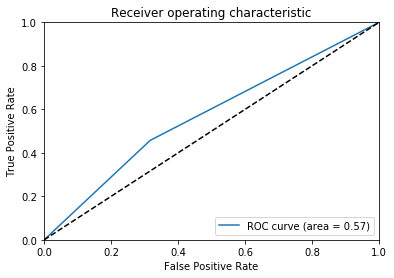

In [14]:
# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

In [15]:
fpr, tpr, thresholds = roc_curve(train['open_account_flg'], y_predicted)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.603965


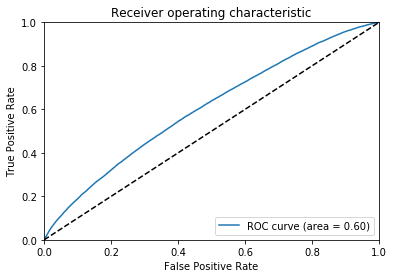

In [16]:
# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()

## 4. Добавление данных, инжиниринг фич, чистка данных, кодирование.
### были добавлены данные по регионам: 
### - средняя зарплата по возрастным группам
### - население по возрастным группам и уровню образования

Нормализованы названия регионов, заполнены пропуски (средние значения для социальной группы), 

категориальные переменные закодированы One-Hot кодированием.

## 5. Срез состояния и анализ

### конкурс даёт дополнительную информацию в виде результатов других участников:

![topic](meetup_10_Mar_img1.png)

## 6. Почему регионы написаны по разному

In [17]:
train['living_region'][train['living_region'].str.match('МОСКОВСКА', as_indexer=True, na=False)].value_counts()

МОСКОВСКАЯ ОБЛ        368
МОСКОВСКАЯ ОБЛАСТЬ    231
МОСКОВСКАЯ              8
Name: living_region, dtype: int64

In [18]:
train['living_region'][train['living_region'].str.match('ТОМСК', as_indexer=True, na=False)].value_counts()

ТОМСКАЯ ОБЛ        354
ТОМСКАЯ ОБЛАСТЬ    221
ТОМСКАЯ              1
Name: living_region, dtype: int64

In [19]:
train['open_account_flg'][train['living_region'].str.match('^ОБЛ ', as_indexer=True, na=False)]\
    .describe()[['count', 'mean']]

count    58872.000000
mean         0.169062
Name: open_account_flg, dtype: float64

In [20]:
train['open_account_flg'][train['living_region'].str.match('.* ОБЛ$', as_indexer=True, na=False)]\
    .describe()[['count', 'mean']]

count    23267.000000
mean         0.200112
Name: open_account_flg, dtype: float64

In [21]:
train['open_account_flg'][train['living_region'].str.match('.*ОБЛАСТЬ', as_indexer=True, na=False)]\
    .describe()[['count', 'mean']]

count    11973.000000
mean         0.143406
Name: open_account_flg, dtype: float64

In [22]:
train['living_region'][train['living_region'].str.match('МОСКВА', as_indexer=True, na=False)].value_counts()

МОСКВА      5529
МОСКВА Г    3647
Name: living_region, dtype: int64

In [23]:
train['open_account_flg'][train['living_region'].str.match('^МОСКВА$', as_indexer=True, na=False)]\
    .describe()[['count', 'mean']]

count    5529.000000
mean        0.232049
Name: open_account_flg, dtype: float64

In [24]:
train['open_account_flg'][train['living_region'].str.match('^МОСКВА Г$', as_indexer=True, na=False)]\
    .describe()[['count', 'mean']]

count    3647.000000
mean        0.167809
Name: open_account_flg, dtype: float64

### ! способ написания региона несет дополнительную информацию !

## 7. Визуальный анализ

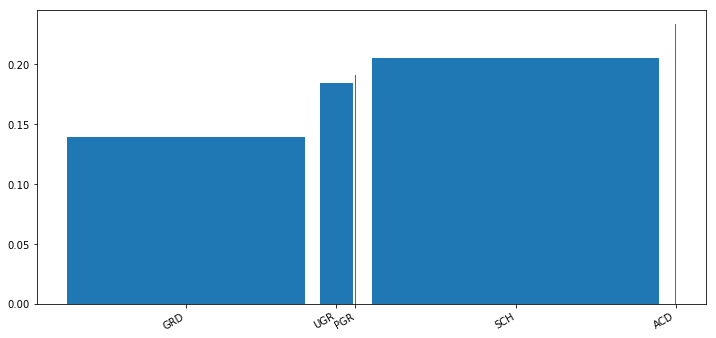

In [25]:
edu = train[['education','open_account_flg']].groupby('education').agg(['mean', 'count']).sort_values(('open_account_flg','mean'))
edu_bins = []
s = 0
for c in edu[('open_account_flg','count')]:
    edu_bins.append(s+c/2.0)
    s += c
fig = plt.figure(figsize=(12,6))

width = edu_bins[-1]
ind = np.arange(len(edu[('open_account_flg','count')]))
plt.bar(edu_bins, edu[('open_account_flg','mean')], width=0.9*edu[('open_account_flg','count')])
plt.xticks(edu_bins, list(edu.index))

fig.autofmt_xdate()

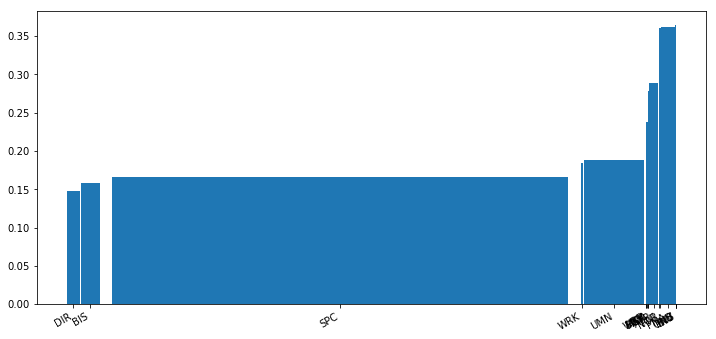

In [26]:
job = train[['job_position','open_account_flg']]\
        .groupby('job_position')\
        .agg(['mean', 'count'])\
        .sort_values(('open_account_flg','mean'))
job_bins = []
s = 0
for c in job[('open_account_flg','count')]:
    job_bins.append(s+c/2.0)
    s += c
fig = plt.figure(figsize=(12,6))

#drop last three outliers
plt.bar(job_bins[:-3], job[('open_account_flg','mean')][:-3], width=0.95*job[('open_account_flg','count')][:-3])
plt.xticks(job_bins, list(job.index))

fig.autofmt_xdate()

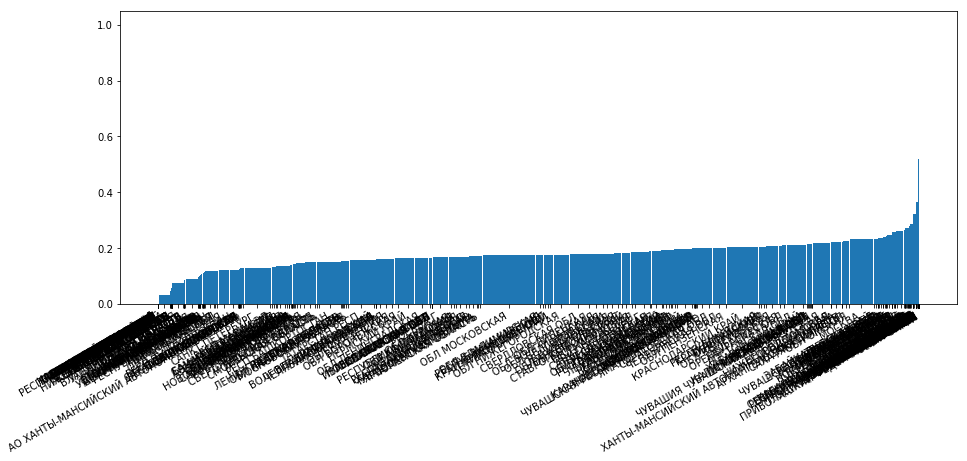

In [27]:
region = train[['living_region','open_account_flg']]\
        .groupby('living_region')\
        .agg(['mean', 'count'])\
        .sort_values(('open_account_flg','mean'))
region_bins = []
s = 0
for c in region[('open_account_flg','count')]:
    region_bins.append(s+c/2.0)
    s += c
fig = plt.figure(figsize=(15,6))

#drop single last outlier
plt.bar(region_bins[:-1], region[('open_account_flg','mean')][:-1], width=0.95*region[('open_account_flg','count')][:-1])
plt.xticks(region_bins, list(region.index))

fig.autofmt_xdate()

Посмотрим на карте:

Процент
![map](meetup_10_Mar_img2.png)

Количество
![map](meetup_10_Mar_img3.png)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d5889a748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4d48e7c588>]], dtype=object)

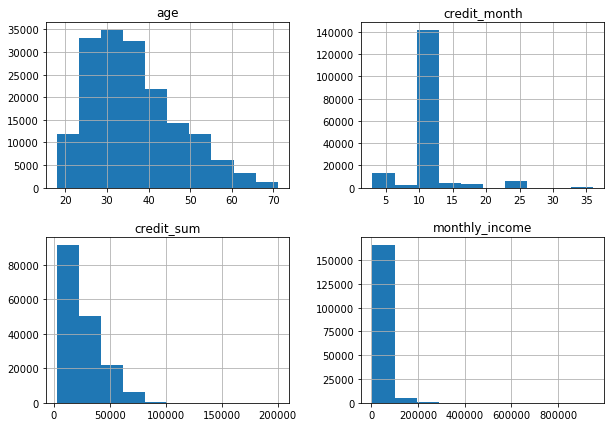

In [28]:
train[['age', 'monthly_income', 'credit_sum', 'credit_month']].hist(figsize=(10,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d48e0f400>]], dtype=object)

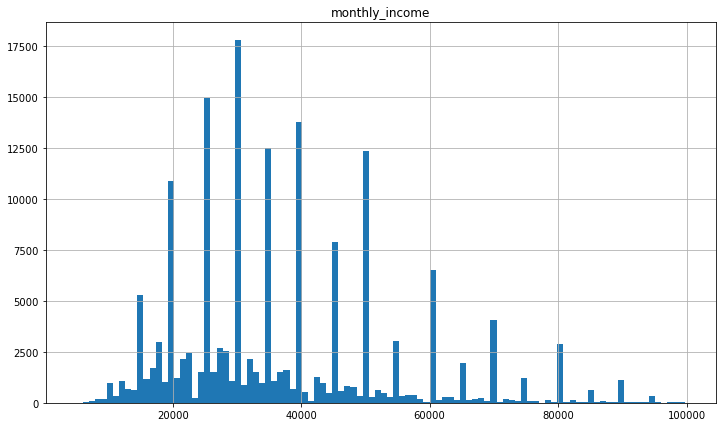

In [29]:
train[train['monthly_income'] < 100000][['monthly_income']].hist(bins=100, figsize=(12,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d588df278>]], dtype=object)

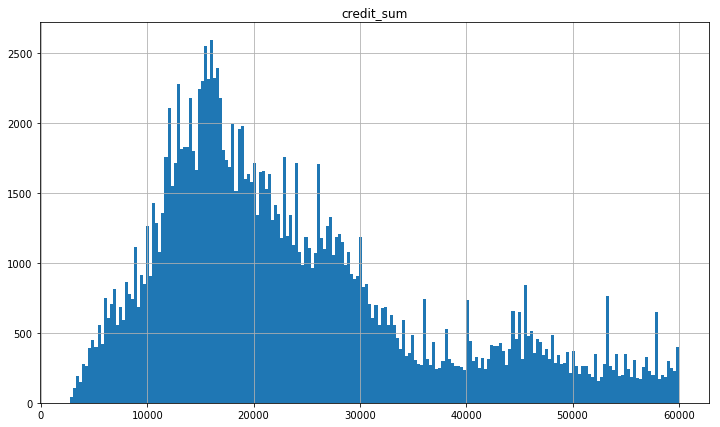

In [30]:
train[train['credit_sum'] < 60000][['credit_sum']].hist(bins=200, figsize=(12,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d485b9198>]], dtype=object)

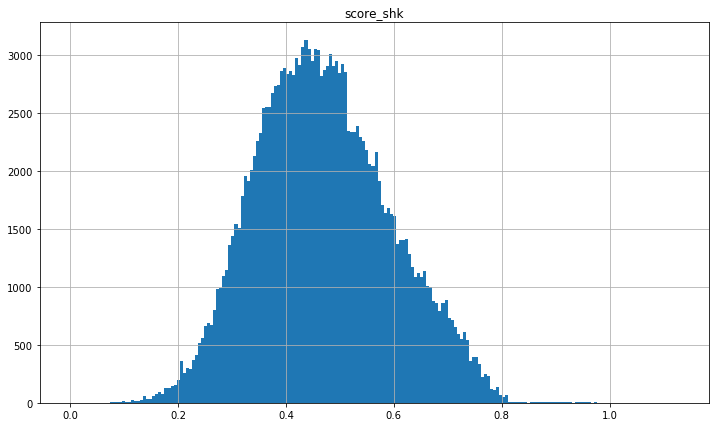

In [35]:
train[['score_shk']].hist(bins=200, figsize=(12,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d22c257f0>]], dtype=object)

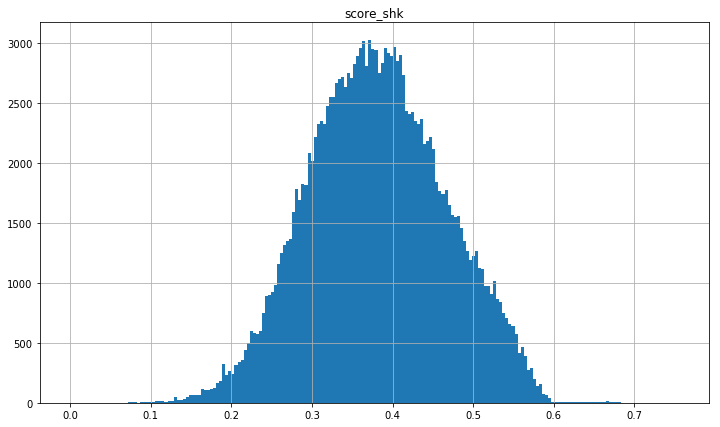

In [43]:
(np.log(1+train[['score_shk']])).hist(bins=200, figsize=(12,7))

### Новые фичи: 
#### кратность monthly_income к 5000 и к 1000
#### кратность credit_sum к 1000 и 100

## 8. Дубликаты записей

### Да, мы подали заявку на получение кредита!
### Условия нам не понравились и мы подали еще одну.

In [31]:
user_specific_columns = ['gender', 'age', 'marital_status', 'job_position', 'score_shk', 'education', 
                         'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count']

In [33]:
sum(train.duplicated(subset=user_specific_columns,keep=False))

13369

In [34]:
train['open_account_flg'][train.duplicated(subset=user_specific_columns,keep=False)]\
    .describe()[['count', 'mean']]

count    13369.000000
mean         0.093874
Name: open_account_flg, dtype: float64

### Новые фичи: 
#### флаг повторяемости записи

#### более продвинутый вариант - построить модель, определяющую вероятность взятия кредита из нескольких заявок

## 9. Стэкирование моделей

### блендинг - усреднение нескольких моделей
### R = 0.5 * M1 + 0.5 * M2

Пример - 12-ое место: https://github.com/TAPAKAH68/tinkoff_challenge_1



### Более сложный пример - пять моделей с подбором коэффициэнтов (3-е место):
https://github.com/VasiliyRubtsov/Tinkoff/blob/master/tinkof_1.ipynb
